# Исследование гипотез интернет-магазина



## Цель исследования

Проанализировать гипотезы и запустить A/B-тест для увеличения выручки интернет-магазина 

## Задачи исследования

* Приоритизировать гипотезы по увеличению выручки интернет-магазина
* Проанализировать A/B-тест

## Описание данных

В нашем распоряжении три датасета.

Файл `hypothesis.csv`, который содержит гипотезы и файлы `orders.csv, visitors.csv`, в которых содержится информация о заказах и посещениях.


**Структура** `hypothesis.csv`
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Структура** `orders.csv`
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

**Структура** `visitors.csv`
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Изучение общей информации

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import warnings 
from tqdm.notebook import tqdm
import requests

sns.set_theme(style="darkgrid")
# sns.set_palette("Greys_r")
warnings.simplefilter('ignore')
tqdm.pandas()

### Обзор данных

In [2]:
data = ['hypothesis.csv', 'orders.csv', 'visitors.csv']
path = open('link.txt', 'r').readline()

for file in data:
    try:
        response = requests.get(path + file)
        response.raise_for_status()
    except requests.exceptions.HTTPError:
        path = '/datasets/'

hypothesis = pd.read_csv(path + data[0], dtype={'Reach':'uint', 'Impact': 'uint', 'Confidence': 'uint', 'Efforts': 'uint'})

orders = pd.read_csv(path + data[1], dtype={'group': pd.CategoricalDtype(['A', 'B'], ordered=True), 'transactionId': 'uint', 'visitorId': 'uint', 'revenue': 'uint'}, parse_dates=['date'])

visitors = pd.read_csv(path + data[2], dtype={'group': pd.CategoricalDtype(['A', 'B'], ordered=True), 'visitors': 'uint'}, parse_dates=['date'])

In [3]:
def sep_text(text):
    """Функция для разделения текста hr"""
    return print(f'''
===============================================================
{text: ^64}
===============================================================
    ''')

In [4]:
def brows_data(data, name):
    """Отображение основных параметров - df, info, describe, dtypes"""
    data.name = name
    sep_text('DataFrame' + ': ' + name)
    display(data)
    sep_text('Info' + ': ' + name)
    display(data.info())
    sep_text('Describe' + ': ' + name)
    display(data.describe().T)
    sep_text('Dtypes' + ': ' + name)
    display(data.dtypes)

Выведем краткую информацию о данных:

In [5]:
data_dict = {'hypothesis':hypothesis, 'orders':orders, 'visitors':visitors}

# добавим отображение строк полностью
pd.set_option('display.max_colwidth', -1)

for name, df in tqdm(data_dict.items()):
    brows_data(df, name)

  0%|          | 0/3 [00:00<?, ?it/s]


                     DataFrame: hypothesis                      
    


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



                        Info: hypothesis                        
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      uint32
 2   Impact      9 non-null      uint32
 3   Confidence  9 non-null      uint32
 4   Efforts     9 non-null      uint32
dtypes: object(1), uint32(4)
memory usage: 344.0+ bytes


None


                      Describe: hypothesis                      
    


,count,mean,std,min,25%,50%,75%,max
Reach,9.0,4.777778,3.153481,1.0,3.0,3.0,8.0,10.0
Impact,9.0,4.777778,3.192874,1.0,3.0,3.0,7.0,10.0
Confidence,9.0,5.555556,3.045944,1.0,3.0,7.0,8.0,9.0
Efforts,9.0,4.888889,2.803767,1.0,3.0,5.0,6.0,10.0



                       Dtypes: hypothesis                       
    


Hypothesis    object
Reach         uint32
Impact        uint32
Confidence    uint32
Efforts       uint32
dtype: object


                       DataFrame: orders                        
    


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A



                          Info: orders                          
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   uint32        
 1   visitorId      1197 non-null   uint32        
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   uint32        
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), uint32(3)
memory usage: 24.8 KB


None


                        Describe: orders                        
    


,count,mean,std,min,25%,50%,75%,max
transactionId,1197.0,2.155621e+09,1.229085e+09,1062393.0,1.166776e+09,2.145194e+09,3.237740e+09,4.293856e+09
visitorId,1197.0,2.165960e+09,1.236014e+09,5114589.0,1.111826e+09,2.217985e+09,3.177606e+09,4.283872e+09
revenue,1197.0,8.348006e+03,3.919113e+04,50.0,1.220000e+03,2.978000e+03,8.290000e+03,1.294500e+06



                         Dtypes: orders                         
    


transactionId    uint32        
visitorId        uint32        
date             datetime64[ns]
revenue          uint32        
group            category      
dtype: object


                      DataFrame: visitors                       
    


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490



                         Info: visitors                         
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     category      
 2   visitors  62 non-null     uint32        
dtypes: category(1), datetime64[ns](1), uint32(1)
memory usage: 1.0 KB


None


                       Describe: visitors                       
    


,count,mean,std,min,25%,50%,75%,max
visitors,62.0,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0



                        Dtypes: visitors                        
    


date        datetime64[ns]
group       category      
visitors    uint32        
dtype: object

Проверим еще на дубликаты:

In [6]:
for name, df in tqdm(data_dict.items()):
    print(f"Подсчет дубликатов в DataFrame {name}: {df.duplicated().sum()}")

  0%|          | 0/3 [00:00<?, ?it/s]

Подсчет дубликатов в DataFrame hypothesis: 0
Подсчет дубликатов в DataFrame orders: 0
Подсчет дубликатов в DataFrame visitors: 0


### Выводы

После обзора данных, можно сделать следующие выводы:
1. Пропусков в данных нет, что не может не радовать,
2. Выбросов тоже не было замечано,
3. Столбцы на этапе открытия преобразовали к нужным типам данных,
4. Дубликатов в данных нет - и это прекрасно! :)
5. Столбцы `hypothesis` было бы неплохо переименовать в нижний регистр.

## Подготовка данных

### Переименование столбцов

Пререименуем столбцы датафрейма `hypothesis` в нижний регистр

In [7]:
hypothesis.columns = hypothesis.columns.str.lower()

## Приоретизация гипотез

Воспользуемся фреймворками `ICE, RICE` для приоретазации гипотез

### Применение фреймворка `ICE`

In [8]:
hypothesis['ice'] = ((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending = False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Применение фреймворка `RICE`

In [9]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending = False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Выводы

Наиболее перспективные гипотезы по `ICE`:
1. **(8)** Запустить акцию, дающую скидку на товар в день рождения
2. **(0)** Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. **(7)** Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Наиболее перспективные гипотезы по `RICE`:
1. **(7)** Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. **(2)** Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. **(0)** Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. **(6)** Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
5. **(8)** Запустить акцию, дающую скидку на товар в день рождения


Как видим список перспективных гипотез изменился, на первое место вышла **(7)** гипотеза, когда как **(8)** спустилась аж на 5-ое место.

Так получилось, потому что параметр **Reach** гипотезы **(7)** равен 10, когда как у **(8)** он лишь равен 1, таким образом параметр Reach повлиял на список перспективных гипотез.

## Анализ A/B-теста

### Построим график кумулятивной выручки по группам

Чтобы построить график, нужно собрать кумулятивные данные. 

Создаем массив уникальных пар значений дат и групп теста:

In [10]:
datesGroups = orders[['date','group']].drop_duplicates()

Получаем агрегированные кумулятивные по дням данные о заказах и посетителях интернет-магазина

In [11]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


Выделим 2 датафрейма, в котором будем хранить кумулятивное количество заказов и выручки по дням по группам A и B:

In [12]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


In [13]:
def draw_nplot(df, column_x, column_y, xlabel, ylabel, title, figsize=(15,8)):
    '''Get dict with some df's and plot line plot. 
    example dict: data_dict = {'cumulativeRevenueA': [cumulativeRevenueA, 'A'], 'cumulativeRevenueB':[cumulativeRevenueB, 'B']}
    '''
    plt.figure(figsize=figsize)
    for key, value in df.items():
        # value[0] contain df, value[1] - label for this df
        plt.plot(column_x, column_y, data = value[0], label = value[1])
    plt.legend()
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title, fontsize=18, fontweight=0, color='black')
    plt.show()
    

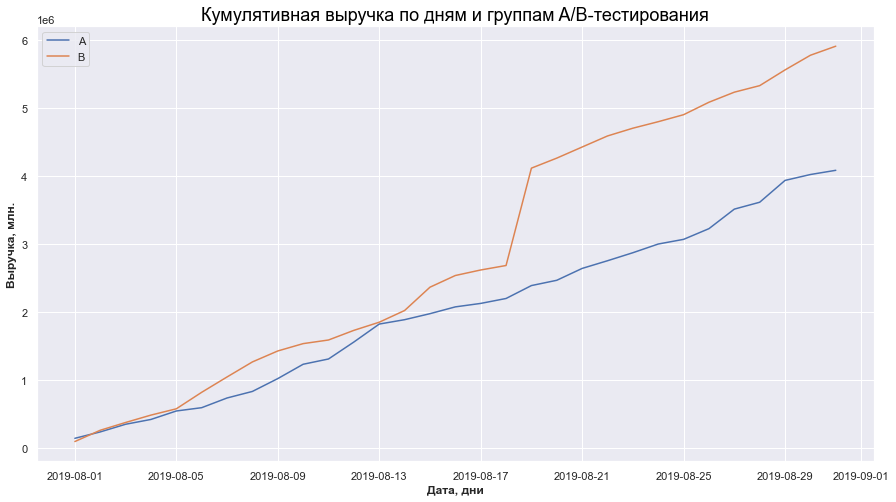

In [14]:
data_dict = {'cumulativeRevenueA': [cumulativeRevenueA, 'A'], 'cumulativeRevenueB':[cumulativeRevenueB, 'B']}
draw_nplot(data_dict, 'date', 'revenue', 'Дата, дни', 'Выручка, млн.', 'Кумулятивная выручка по дням и группам A/B-тестирования')

Выручка почти равномерно увеличивается в течении всего теста, однако график группы **B** в нескольких точках резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем ниже.


### Построим график кумулятивного среднего чека по группам

In [15]:
for df in [cumulativeRevenueA, cumulativeRevenueB]:
    df['mean_revenue'] = df['revenue'] / df['orders']

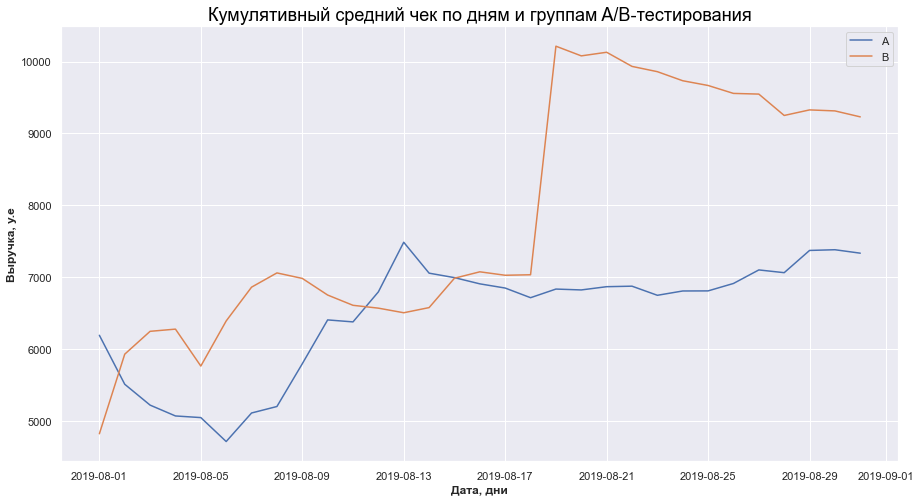

In [16]:
draw_nplot(data_dict, 'date', 'mean_revenue', 'Дата, дни', 'Выручка, у.е', 'Кумулятивный средний чек по дням и группам A/B-тестирования')

Средний чек ближе к окончанию тестирования резко возрастает у группы **B**, возможно туда попали очень крупные заказы, тогда нам потребуется больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

### График относительного изменения кумулятивного среднего чека группу B к группе A

Соберем данные в одном датафрейме

In [17]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [18]:
mergedCumulativeRevenue['diff_BA_mean_revenue'] = (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1

In [19]:
def draw_plot(df, column_x, column_y, xlabel, ylabel, title, axhline = 0, figsize=(15,8)):
    plt.figure(figsize=figsize)
    plt.plot(column_x, column_y, data = df)
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title, fontsize=18, fontweight=0, color='black')
    plt.axhline(y=axhline, color='black', linestyle='--') 
    plt.show()
    

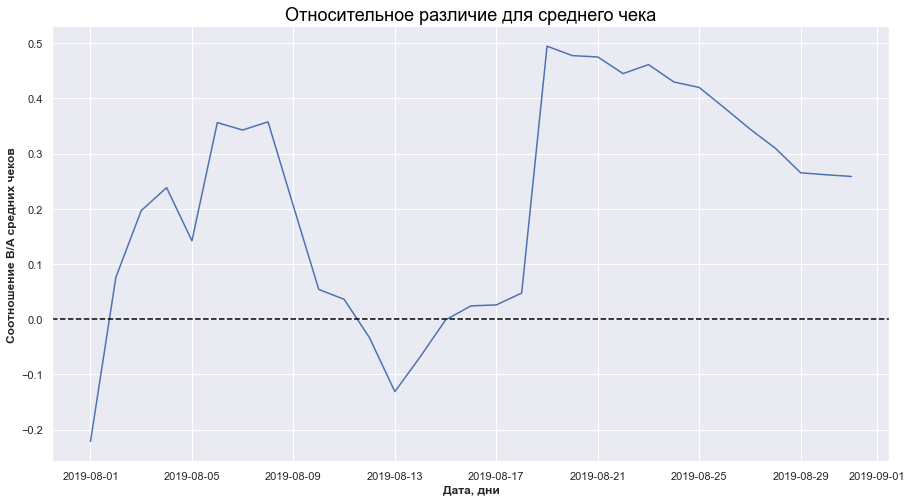

In [20]:
draw_plot(mergedCumulativeRevenue, 'date', 'diff_BA_mean_revenue', 'Дата, дни', 'Соотношение B/A средних чеков', 'Относительное различие для среднего чека')

В нескольких точках график различия между сегментами резко "скачет", точно где-то спряталась крупные заказы и выбросы! Проанализуем их на точечном графике количества заказов по пользователям чуть позже.

### График кумулятивной конверсии по группам

Аналогично проанализируем графки кумулятивной конверсии:

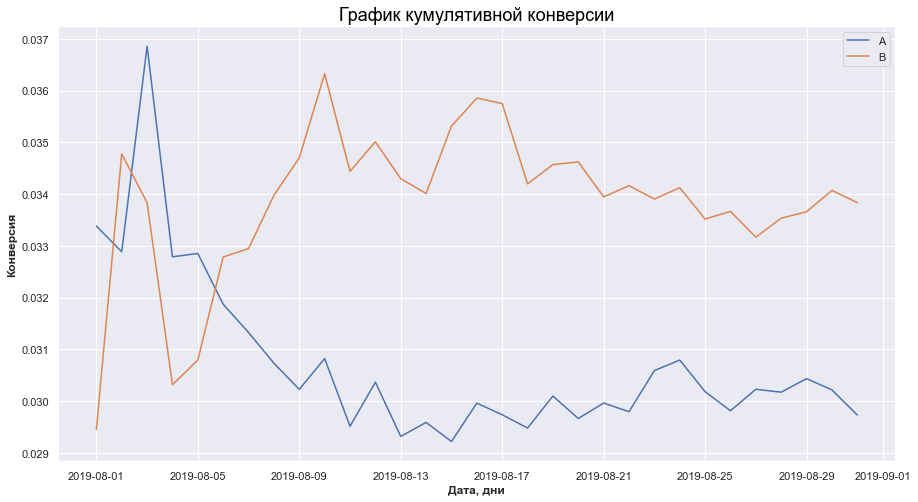

In [21]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группам
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
data_dict = {'cumulativeDataA': [cumulativeDataA, 'A'], 'cumulativeDataB':[cumulativeDataB, 'B']}
draw_nplot(data_dict, 'date', 'conversion', 'Дата, дни', 'Конверсия', 'График кумулятивной конверсии')

Получаем почти симметричный график относительно значения 0.032. Группа B вырвалась вперед, когда как группа A значительно просела.

### График относительного изменения кумулятивной конверсии группы В к группе А

Построим график относительного различия кумулятивных конверсий:

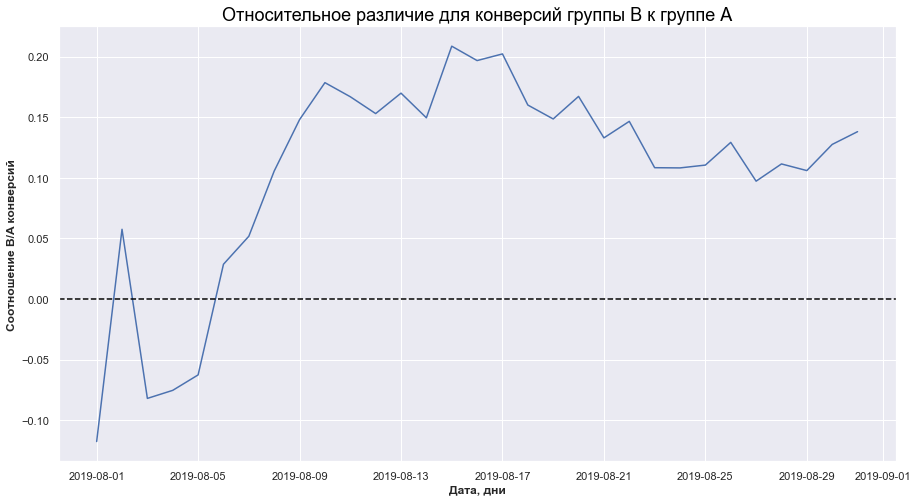

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversions['diff_BA_conversion'] = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1
draw_plot(
    mergedCumulativeConversions,
    'date', 
    'diff_BA_conversion',
    'Дата, дни', 
    'Соотношение B/A конверсий', 
    'Относительное различие для конверсий группы В к группе А'
    )


В начале конверсия группы В проигрывала группе А, но затем стремительно вырвалась вперед и установилась в диапазоне 0.1-0.15.

### Точечный график количества заказов по пользователям

Оценим количество заказов пользователей по точечному графику, для этого создадим датафрейм, который будет содержать количество заказов на пользователей

In [23]:
ordersByUsers = (
    orders.drop(['group','date', 'revenue'], axis=1)
    .groupby('visitorId', as_index = False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['userId', 'orders']

In [24]:
def draw_scatter(df, column, xlabel, ylabel, title, alpha = 0.5, figsize=(15,8)):
    x_value = pd.Series(range(0, len(df[column])))
    plt.figure(figsize=figsize)
    plt.scatter(x_value, df[column], alpha = alpha)
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title, fontsize=18, fontweight=0, color='black')
    plt.show()

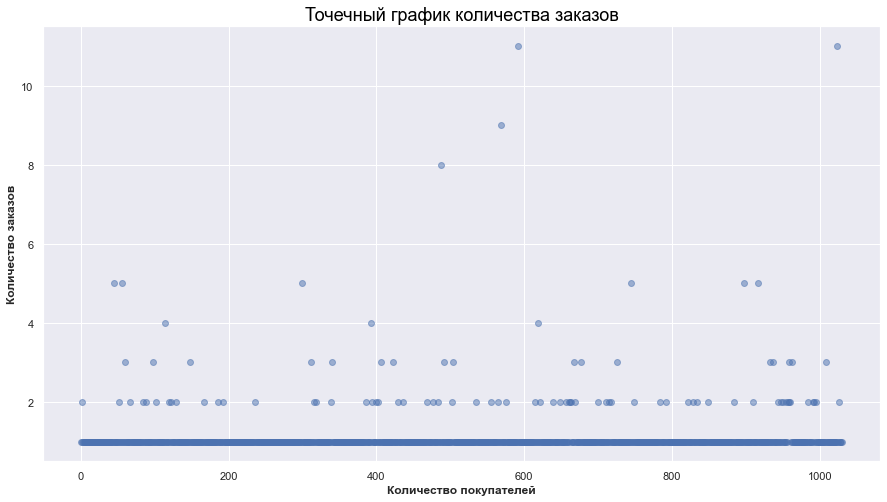

In [25]:
draw_scatter(ordersByUsers, 'orders', 'Количество покупателей', 'Количество заказов', 'Точечный график количества заказов')

Как мы видим много пользователей с 2-4 заказами, их доля неясна, поэтому непонятно можно считать их аномалиями или нет.

### Посчитаем перцентили количества заказов

In [26]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


10% пользователей оформляло больше, чем 1 заказ и 5% оформляло больше 2 заказов. Выберем значения большие 2 заказов за аномальные.

### Точечный график стоимостей заказов

Построим теперь точечную диаграмму для стоимостей заказов пользователей

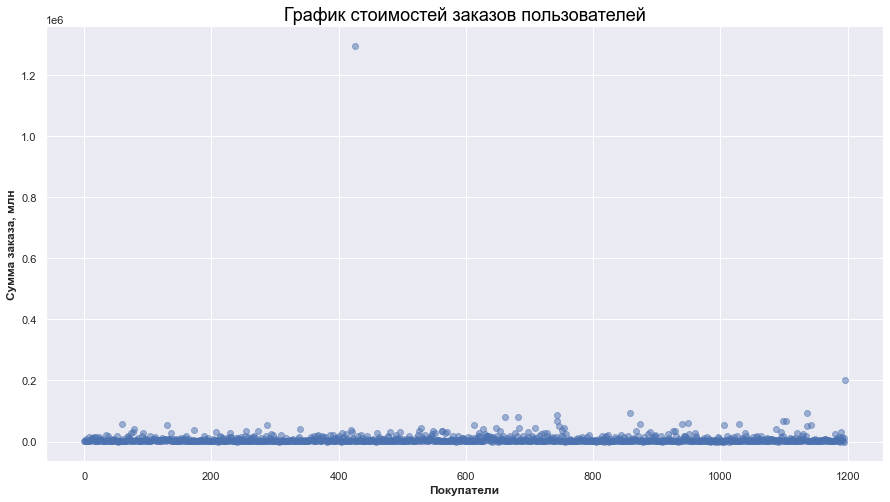

In [27]:
draw_scatter(orders, 'revenue', 'Покупатели', 'Сумма заказа, млн', 'График стоимостей заказов пользователей')

Все как и предполагали, есть заказы, которые выбиваются из общей массы: за 1,3 млн. и 200 000.

### Посчитаем перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили для того, чтобы определить границу аномальных заказов

In [28]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов дороже 28 000 у.е. и не более 1% дороже 58 233 у.е. Выберем 95% как границу аномальных заказов и все, что свыше 28 000 будем считать аномальными значениями.

### Статистическая значимость различий в конверсии между группами по "сырым" данным

Сформулируем гипотезы для анализа:
```
Н0: Различие между конверсиями группы А и В нет.
Н1: Различие между конверсиями группы А и В есть.
```



Посчитаем статистическую значимость различия в конверсии между группами. Создадим переменные, в которых будем хранить пользователей, которые заказывали хотя бы 1 раз:

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

Объявим переменные `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [30]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(cumulativeDataA['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(cumulativeDataB['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

In [31]:
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.007
0.144


Первое значение - p-value, которое меньше 0.05, значит нулевую гипотезу о том, что стастически значимых различий нет - отвергаем. 
Второе значение относительный выигрышь группы В составляет 14.4%.

### Статистическая значимость различий в среднем чеке заказа между группами по "сырым" данным

Найдём относительные различия в среднем чеке между группами:

In [32]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

### Статистическая значимость различий в конверсии между группами по "очищенным" данным

Сформулируем гипотезы для анализа:
```
Н0: Различие между конверсиями группы А и В нет.
Н1: Различие между конверсиями группы А и В есть.
```

Найденные в прошлых этапах 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 у.е. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ стоимостью дороже 28 000. Так мы уберем 1% с наибольшим числом заказов и 5% пользователей с дорогими заказами.

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [33]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ], axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: uint64
(74,)


Всего 74 аномальных пользователей.

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [34]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index=np.arange(cumulativeDataA['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], pd.Series(0,index=np.arange(cumulativeDataB['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)


In [35]:
print('{0:.5f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00575
0.178


Результат по конверсии практически не изменился. Количество аномальных заказов было не очень существенным. Посмотрим, что случится с средним чеком.

### Статистическая значимость различий в среднем чеке между группами по "очищенным" данным

Сформулируем гипотезы для анализа:
```
Н0: Различие между средними чеками группы А и В нет.
Н1: Различие между средними чеками группы А и В есть.
```

In [36]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.369
-0.020


P-value увеличился, но и разница между сегментами сократилась с 26% до почти 1%, причем средний чек у группы А оказался больше.

Такой пример хорошо показывает, как сильно аномалии повлияли на результаты A/B-теста.

## Результаты A/B-теста

По результатам A/B-теста можно сказать, что **нужно остановить тест и зафиксировать победу группы B**.

Кумулятивные метрики группы В относительно А зафиксировались.

Конверсия группы В по сырым и очищенным данным выше конверсии группы А примерно на 15-17%. Средний чек по сырым и очищенным данным различий не имеет, как видно после очистки от аномалий, получается, что различие среднего чека группа А и В около 1%. 

Таким образом можно сказать, что у группы В конверсия выше на 17% по очищенным данным, а средний чек по отношению к группе А не изменился. 